In [237]:

import matplotlib as mpl

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 25
mpl.rcParams['text.usetex'] = False

# Heron-based formula

In [238]:
def dual_edge_length(vp1, vp2):
    """
    Compute the dual edge length |e*_{ij}| using Heron's formula
    for the barycentric dual of a primal edge vp1-vp2.
    """
    # Get the dual vertices (centroids of triangles sharing edge vp1-vp2)
    vd_dual = list(vp1.vd.intersection(vp2.vd))
    if len(vd_dual) < 2:
        return 0.0  # boundary or degenerate edge

    # Positions of the two dual vertices
    A = vd_dual[0].x_a
    B = vd_dual[1].x_a

    # Heron's formula: length of edge AB
    return np.linalg.norm(A - B)


def div_u_heron(vp1, dim=2):
    """
    Compute integrated divergence of velocity at vertex vp1
    using barycentric dual and Heron's formula for dual edges.
    """
    div_i = 0.0
    centroid_vp1 = np.mean([vd.x_a for vd in vp1.vd], axis=0)

    for vp2 in vp1.nn:
        l_dual = dual_edge_length(vp1, vp2)
        if l_dual == 0:
            continue

        # Get dual vertices again for orientation
        vd_dual = list(vp1.vd.intersection(vp2.vd))
        dual_vec = vd_dual[1].x_a - vd_dual[0].x_a

        # Outward normal (rotate 90° CCW)
        n_ij = np.array([-dual_vec[1], dual_vec[0]]) / np.linalg.norm(dual_vec)

        # Ensure outward direction
        mid_dual = 0.5 * (vd_dual[0].x_a + vd_dual[1].x_a)
        if np.dot(mid_dual - centroid_vp1, n_ij) < 0:
            n_ij *= -1

        # Integrated flux
        delta_u = vp2.u - vp1.u
        div_i += l_dual * np.dot(delta_u, n_ij)

    return div_i




def dP_heron(vp1, dim=2):
    """
    Integrated pressure gradient at vertex vp1 using Heron-based dual edges.
    Formula: Sum_j [ |dual_edge_ij| * (P_j - P_i) * n_ij ]
    """
    dP_i = np.zeros(dim)
    centroid_vp1 = np.mean([vd.x_a for vd in vp1.vd], axis=0)

    for vp2 in vp1.nn:
        l_dual = dual_edge_length(vp1, vp2)
        if l_dual == 0:
            continue

        # Outward normal
        vd_dual = list(vp1.vd.intersection(vp2.vd))
        dual_vec = vd_dual[1].x_a - vd_dual[0].x_a
        n_ij = np.array([-dual_vec[1], dual_vec[0]]) / np.linalg.norm(dual_vec)

        # Correct orientation
        mid_dual = 0.5 * (vd_dual[0].x_a + vd_dual[1].x_a)
        if np.dot(mid_dual - centroid_vp1, n_ij) < 0:
            n_ij *= -1

        # Pressure difference
        delta_P = vp2.P - vp1.P
        dP_i += l_dual * delta_P * n_ij

    return dP_i


def du_heron(vp1, dim=2):
    """
    Integrated velocity Laplacian at vertex vp1 using Heron-based dual edges.
    L(u)_i = Sum_j [ |dual_edge_ij| / |primal_edge_ij| * (u_j - u_i) ]
    """
    du_i = np.zeros_like(vp1.u)
    centroid_vp1 = np.mean([vd.x_a for vd in vp1.vd], axis=0)

    for vp2 in vp1.nn:
        # Primal edge length
        l_ij = np.linalg.norm(vp2.x_a - vp1.x_a)
        if l_ij == 0:
            continue

        # Dual edge length
        l_dual = dual_edge_length(vp1, vp2)
        if l_dual == 0:
            continue

        w_ij = l_dual / l_ij
        du_i += w_ij * (vp2.u - vp1.u)

    return du_i


# Laplacian of the pressure

In [239]:
def laplace_P(vp1):
    """
    Scalar Laplacian of pressure at vertex vp1 using Heron-based dual edges.
    ΔP_i ≈ (1 / |V_i*|) Σ_j |e*_ij| (P_j - P_i)
    """
    delta = 0.0
    A_i = d_area_barycentric(vp1)  # dual area

    for vp2 in vp1.nn:
        # Dual edge length
        l_dual = dual_edge_length(vp1, vp2)
        if l_dual == 0:
            continue

        # Pressure difference
        delta_P = vp2.P - vp1.P

        # Add contribution to Laplacian
        delta += l_dual * delta_P

    return delta / A_i


# New functions

In [240]:


import polyscope as ps

from ddgclib._complex import Complex
from ddgclib.hyperct._vertex import VertexCacheField


def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2 == 0] = 1
    return a / np.expand_dims(l2, axis)

def distance(a, b):
    return np.linalg.norm(a - b)

def barycenter(vertices):
    """
    Compute the barycenter (centroid) of a set of vertices
    """
    return np.mean(vertices, axis=0)


# Geometry Helpers


def area_of_polygon(points):
    """Calculates the area of a polygon in 3D space."""
    # Calculate the cross product of each pair of adjacent edges.
    edges = points[1:] - points[:-1]
    cross_products = np.cross(edges[:-1], edges[1:])
    # Calculate the area of the triangle formed by each pair of adjacent edges
    triangle_areas = 0.5 * np.linalg.norm(cross_products, axis=1)
    return np.sum(triangle_areas)

def volume_of_geometric_object(points, extra_point):
    """Calculates volume of pyramid defined by base points and extra_point apex."""
    normal_vector = np.cross(points[1] - points[0], points[2] - points[0])
    projected_extra_point = extra_point - np.dot(extra_point - points[0], normal_vector) / np.linalg.norm(normal_vector)**2 * normal_vector
    distance = np.linalg.norm(extra_point - projected_extra_point)
    base_area = area_of_polygon(points)
    volume = 1/3 * base_area * distance
    return volume


# Dual Construction


def compute_vd_barycentric(HC, cdist=1e-10):
    """
    Computes the dual mesh using the barycentric formalism.

    1. Dual vertices are centroids of the simplices (triangles in 2D).
    2. Boundary dual vertices are the midpoints of boundary edges (in 2D).
    3. Populates HC.Vd and connects dual vertices to form the dual graph.

    :param HC: Complex object
    :param cdist: tolerance for merging vertices (to handle float drift)
    :return: HC with populated Vd
    """
    # Initialize dual vertex cache
    HC.Vd = VertexCacheField()

    # Reset dual sets on primal vertices
    for v in HC.V:
        v.vd = set()

    # 1. Create Dual Vertices (Centroids of Triangles)
    # Iterate over primal vertices to find connected simplices
    for v1 in HC.V:
        for v2 in v1.nn:
            # Find shared neighbors to identify a simplex (triangle v1-v2-v3)
            shared = v1.nn.intersection(v2.nn)

            for v3 in shared:
                # Calculate Barycenter (Centroid)
                verts = np.array([v1.x_a, v2.x_a, v3.x_a])
                cd = np.mean(verts, axis=0)

                # Check uniqueness to handle floating point drift
                # (We search existing duals to merge if very close)
                for vd_i in HC.Vd:
                    if np.linalg.norm(vd_i.x_a - cd) < cdist:
                        cd = vd_i.x_a
                        break

                # Get or create dual vertex
                vd = HC.Vd[tuple(cd)]

                # Register this dual vertex to the surrounding primal vertices
                for v in [v1, v2, v3]:
                    v.vd.add(vd)
                    # Note: We do NOT add primal vertices to vd.nn here.
                    # vd.nn is reserved for dual-dual connections.

    # 2. Handle Boundaries (Midpoints of Boundary Edges)
    # If an edge (v1, v2) is on the boundary, we place a dual node at its midpoint
    # to close the dual control volume.
    for v1 in HC.V:
        if not v1.boundary: continue
        for v2 in v1.nn:
            if not v2.boundary: continue

            # Identify if this edge is strictly a boundary edge.
            # In a 2D triangulation, an internal edge has 2 shared neighbors (2 triangles).
            # A boundary edge has only 1 shared neighbor (1 triangle).
            shared = v1.nn.intersection(v2.nn)
            if len(shared) == 1:
                midpoint = (v1.x_a + v2.x_a) / 2.0

                # Merge check
                for vd_i in HC.Vd:
                    if np.linalg.norm(vd_i.x_a - midpoint) < cdist:
                        midpoint = vd_i.x_a
                        break

                vd_bound = HC.Vd[tuple(midpoint)]
                v1.vd.add(vd_bound)
                v2.vd.add(vd_bound)

    # 3. Connect Dual Vertices (Create Dual Edges)
    # A dual edge exists between two dual vertices if they share a primal edge face.
    # In 2D: Two centroids (or a centroid and a boundary midpoint) are connected
    # if they are associated with the same primal edge (v1, v2).
    for v1 in HC.V:
        for v2 in v1.nn:
            # The intersection of v1.vd and v2.vd gives the dual vertices
            # surrounding the edge v1-v2.
            common_duals = list(v1.vd.intersection(v2.vd))

            # In 2D:
            # - Internal edge: Shared by 2 triangles -> 2 Barycenters -> Connect them.
            # - Boundary edge: Shared by 1 triangle + Boundary -> 1 Barycenter + 1 Midpoint -> Connect them.
            if len(common_duals) == 2:
                d1 = common_duals[0]
                d2 = common_duals[1]
                d1.connect(d2)

    return HC


def triang_dual(points, plot_delaunay=False):
    """
    Compute the Delaunay triangulation of a set of points and initialize the Complex.

    :param points: (N, 2) or (N, 3) numpy array of points
    :param plot_delaunay: bool, whether to plot the initial triangulation
    :return: HC (Complex object), tri (Delaunay object)
    """
    dim = points.shape[1]
    tri = Delaunay(points)

    if plot_delaunay:
        plt.figure()
        plt.triplot(points[:,0], points[:,1], tri.simplices)
        plt.plot(points[:,0], points[:,1], 'o')
        plt.show()

    # Put Delaunay connectivity into hyperct Complex object
    HC = Complex(dim)

    # Initialize vertices in HC
    # (Doing this explicitly ensures all points exist even if isolated, though Delaunay won't have isolated points)
    for p in points:
        HC.V[tuple(p)]

    # Add connections
    for s in tri.simplices:
        # Connect every pair in the simplex
        # For a triangle (A, B, C), connect A-B, B-C, C-A
        for i in range(len(s)):
            for j in range(i + 1, len(s)):
                v1i = s[i]
                v2i = s[j]
                v1 = tuple(points[v1i])
                v2 = tuple(points[v2i])
                HC.V[v1].connect(HC.V[v2])

    # Identify boundaries (Simple 2D convex hull approach or based on edge usage)
    # A robust way is to count how many simplices share an edge.
    # Here we assume the user might set them manually or use a helper,
    # but for simple 2D, we can use the convex hull from Delaunay.
    # Marking boundaries is crucial for compute_vd_barycentric to create midpoints.

    # Reset boundaries
    for v in HC.V:
        v.boundary = False

    # Delaunay convex hull vertices are definitely boundary
    for idx in tri.convex_hull.flatten():
         HC.V[tuple(points[idx])].boundary = True

    return HC, tri

# Dual Areas and Edge Lengths

def d_area_barycentric(vp1):
    """
    Computes the dual area of a vertex `vp1` using the barycentric decomposition.

    The area associated with a vertex in the barycentric dual is 1/3 of the
    total area of all triangles sharing that vertex (in 2D).
    """
    darea = 0
    processed_triangles = set()

    # Iterate over neighbors to find all triangles connected to vp1
    for vp2 in vp1.nn:
        # Find shared neighbors (forming triangles)
        shared = vp1.nn.intersection(vp2.nn)
        for vp3 in shared:
            # Create a unique ID for the triangle to avoid double counting
            # Sort indices or coordinates to ensure uniqueness
            # Using sorted tuple of coordinates if indices aren't reliable
            # (Assuming vertices have unique .index or using coordinates)
            if hasattr(vp1, 'index'):
                tri_id = tuple(sorted([vp1.index, vp2.index, vp3.index]))
            else:
                tri_id = tuple(sorted([vp1.x, vp2.x, vp3.x]))

            if tri_id not in processed_triangles:
                processed_triangles.add(tri_id)

                # Calculate Area of the full triangle T
                A = vp1.x_a
                B = vp2.x_a
                C = vp3.x_a

                # Cross product magnitude for area (2D on XY plane)
                # 0.5 * | (xB-xA)(yC-yA) - (xC-xA)(yB-yA) |
                # Using 3D cross product is safer for general cases
                cross_prod = np.cross(B - A, C - A)
                area_T = 0.5 * np.linalg.norm(cross_prod)

                # In barycentric dual, the vertex gets 1/3 of the triangle's area
                darea += area_T / 3.0

    return darea


def e_star(v_i, v_j, HC, n=None, dim=2):
    """
    Compute the length of the dual edge associated with primal edge v_i - v_j.

    In the barycentric formalism:
    - The dual edge connects the dual vertices (barycenters) associated with the primal edge.
    """
    e_ij_star = 0

    # Intersection of dual sets gives the dual vertices surrounding edge ij
    vdnn = v_i.vd.intersection(v_j.vd)

    if len(vdnn) == 2:
        # Standard internal edge: connects two centroids
        d1 = list(vdnn)[0]
        d2 = list(vdnn)[1]
        e_ij_star = np.linalg.norm(d1.x_a - d2.x_a)
    elif len(vdnn) == 1:
        # Boundary edge case handled in compute_vd_barycentric:
        # If correctly computed, boundary edges should have 2 duals:
        # 1 Triangle Centroid AND 1 Edge Midpoint.
        # If only 1 is found, check if boundary logic triggered correctly.
        pass
    elif len(vdnn) > 2:
        # 3D case: Dual is a face (polygon). Area of that polygon.
        # Collect points and compute polygon area.
        pts = [d.x_a for d in vdnn]
        # (Need to order points to compute area correctly, usually via convex hull or centroid sorting)
        # For now return 0 or implement polygon area if 3D is strictly required.
        pass

    return e_ij_star

def v_star(v_i, v_j, HC, n=None, dim=2):
    """Wrapper for e_star to maintain naming convention (Dual Volume/Area)"""
    return e_star(v_i, v_j, HC, n, dim)



# Discrete Differential Operators


def dP(vp1, dim=2):

    return dP_heron(vp1, dim=2)




def div_u(vp1, dim=2):

    return  div_u_heron(vp1, dim=2)



def du(vp1, dim=3):

    return du_heron(vp1, dim=2)


def dudt(v, dim=3, mu=8.90 * 1e-4):
    """
    Compute acceleration at a vertex.

    dudt = ( -Grad(P) + mu * Lap(u) ) / Mass

    Prerequisites:
    - v.P (Pressure)
    - v.u (Velocity)
    - v.m (Mass, usually set via rho * d_area_barycentric)
    """
    # Force balance
    F_pressure = -dP(v, dim=dim)
    F_viscous = mu * du(v, dim=dim)

    # Acceleration
    accel = (F_pressure + F_viscous) / v.m
    return accel

# Visualization




def plot_dual(vd, HC, vector_field=None, scalar_field=None, fn='', up="x_up",
              stl=False, length_scale=1.0, point_radii=0.005):
    """
    Polyscope 3D visualization of the dual mesh.
    """
    ps.init()
    ps.set_up_dir('z_up')

    # Plot Primal
    HC.vertex_face_mesh() # Generate mesh data
    points = np.array(HC.vertices_fm)
    faces = np.array(HC.simplices_fm_i)

    ps_cloud = ps.register_point_cloud("Primal Points", points)
    ps_cloud.set_radius(point_radii)

    ps_mesh = ps.register_surface_mesh("Primal Mesh", points, faces)
    ps_mesh.set_transparency(0.3)

    # Plot Dual Points
    dual_pts = np.array([v.x_a for v in HC.Vd])
    if len(dual_pts) > 0:
        d_cloud = ps.register_point_cloud("Dual Points", dual_pts)
        d_cloud.set_color((1.0, 0.5, 0.0))
        d_cloud.set_radius(point_radii)

    # Screenshot
    if fn:
        ps.screenshot(fn)

    # ps.show() # Uncomment to allow interactive view
    return ps

# Functions

In [241]:
from scipy.spatial import Delaunay
#import polyscope as ps


# ddg imports
import os, sys
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from ddgclib._complex import *
from ddgclib._sphere import *


def distance(a, b):
    return np.linalg.norm(a - b)




## This test case
# Test case traingulation
def incom_Poi(domain, refinements=2):
    """
    Compute the triangulate of a 2D incompressible Poiseuile flow
    """
    HC = Complex(2, domain)
    HC.triangulate()
    for i in range(refinements):
        HC.refine_all()

    points = []
    for v in HC.V:
        points.append(v.x_a)
    points = np.array(points)
    tri = Delaunay(points)
    return points

def u_x_analytical(y):
    """
    General pipe solution (NOT planar case)
    """
    return 4 * y * (1 - y)

def u_plane_analytical(x):
    y = x[1]
    return (G / 2 * mu) * y * (h - y)

def v_error(HC):
    MSE = 0
    for v in HC.V:
        u_anal = u_plane_analytical(v.x_a)
        MSE += (v.u[1]- u_anal)**2
    return MSE

## Initial conditions
# velocity
def v_IC(HC):
    # Assign velocity field to all points:
    for v in HC.V:
        v.u = np.array([u_ic(v.x_a), 0])

# mass
def mass_IC(HC):
    # Set mass of each fluid particle:
    for v in HC.V:
        # Compute the dual area around a particle:
        area = d_area_barycentric(v)  # <- use barycentric version
        V = area * 1  # m3, can be modified later
        # Set mass in kg
        v.m = rho * V

def plot_dual_mesh_2D(HC, tri):
    """
    Plot the dual mesh and show edge connectivity. Blue is the primary mesh. Orange is the dual mesh.
    """
    import matplotlib.pyplot as plt

    # Find the dual points
    dual_points = []
    for vd in HC.Vd:
        #print('-')
        #print(vd.x_a)
        dual_points.append(vd.x_a)
        #for vdn in vd.v
    dual_points = np.array(dual_points)

    for v in HC.V:
        # "Connect duals":
        for v2 in v.nn:
            v1vdv2vd = v.vd.intersection(v2.vd)  # Cardinality always 1 or 2?
            if len(v1vdv2vd) == 1:
                continue
            v1vdv2vd = list(v1vdv2vd)
            x = [v1vdv2vd[0].x[0], v1vdv2vd[1].x[0]]
            y = [v1vdv2vd[0].x[1], v1vdv2vd[1].x[1]]
            plt.plot(x, y, color='orange')

        for vd in v.vd:
            x = [v.x[0], vd.x[0]]
            y = [v.x[1], vd.x[1]]
            #plt.plot(x, y, '--', color='tab:green')
    plt.triplot(points[:,0], points[:,1], tri.simplices, color='tab:blue')
    plt.plot(points[:,0], points[:,1],  'o', color='tab:blue')
    plt.plot(dual_points[:,0], dual_points[:,1], 'o', color='tab:orange')

    plt.show()

# Plots
def plot_field(p, u, xlim_lb=-1, xlim_ub=10, scale=1):
    """
    Plot the velocity fields using points `p` and
    associated velocities `u`.

    scale adjusts the scale of the shown arrow factors
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize

    positions = p
    velocities = u

    # Separate the positions and velocities into x, y, u, and v arrays
    x, y = positions[:, 0], positions[:, 1]
    u, v = velocities[:, 0], velocities[:, 1]

    # Calculate the magnitude of the velocity vectors
    magnitude = np.sqrt(u**2 + v**2)  # Should be around 0.1

    # Set the normalization range for the colors of the arrows based on the actual magnitudes
    norm = Normalize(vmin=magnitude.min(), vmax=magnitude.max())

    plt.figure(figsize=(8, 8))
    quiver_plot = plt.quiver(x, y, u, v, magnitude, norm=norm, cmap='viridis', scale=scale)
    plt.scatter(x, y, s=0.1)
    #plt.colorbar(label='Magnitude of Velocity')
    def fmt(x, pos):
        a, b = '{:.2e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    #cbar = plt.colorbar(quiver_plot, format=ticker.FuncFormatter(fmt))
    cbar = plt.colorbar(quiver_plot)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.formatter.set_useMathText(True)
    cbar.set_label('Magnitude of Velocity (m/s)')
    #plt.title('Quiver Plot from Position Points and Velocity Vectors')
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.xlim(xlim_lb, xlim_ub)
    plt.ylim(0, 1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.show()

def plot_discrete_field(p, u, HC, tri, xlim_lb=0, xlim_ub=1, scale=1e-6, save='vector_int.pdf'):
    """
    Plot the velocity fields using points `p` and
    associated velocities `u`.

    vfac adjusts the arrow length to account for very low velocities in the field
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Find the dual points
    dual_points = []
    for vd in HC.Vd:
        #print('-')
        #print(vd.x_a)
        dual_points.append(vd.x_a)
        #for vdn in vd.v
    dual_points = np.array(dual_points)

    for v in HC.V:
        # "Connect duals":
        for v2 in v.nn:
            v1vdv2vd = v.vd.intersection(v2.vd)  # Cardinality always 1 or 2?
            if len(v1vdv2vd) == 1:
                continue
            v1vdv2vd = list(v1vdv2vd)
            x = [v1vdv2vd[0].x[0], v1vdv2vd[1].x[0]]
            y = [v1vdv2vd[0].x[1], v1vdv2vd[1].x[1]]
            plt.plot(x, y, color='orange')

        for vd in v.vd:
            x = [v.x[0], vd.x[0]]
            y = [v.x[1], vd.x[1]]
            #plt.plot(x, y, '--', color='tab:green')
    plt.triplot(points[:,0], points[:,1], tri.simplices, color='tab:blue')
    plt.plot(points[:,0], points[:,1],  'o', color='tab:blue')
    plt.plot(dual_points[:,0], dual_points[:,1], 'o', color='tab:orange')

    ## Velocity
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize

    positions = p
    velocities = u

    # Separate the positions and velocities into x, y, u, and v arrays
    x, y = positions[:, 0], positions[:, 1]
    u, v = velocities[:, 0], velocities[:, 1]

    # Calculate the magnitude of the velocity vectors
    magnitude = np.sqrt(u**2 + v**2)  # Should be around 0.1

    # Set the normalization range for the colors of the arrows based on the actual magnitudes
    norm = Normalize(vmin=magnitude.min(), vmax=magnitude.max())

    #plt.figure(figsize=(8, 8))
    quiver_plot = plt.quiver(x, y, u, v, magnitude, norm=norm, cmap='viridis', scale=scale)
    plt.scatter(x, y, s=0.1)
    #plt.colorbar(label='Magnitude of Velocity')

    def fmt(x, pos):
        a, b = '{:.2e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    #cbar = plt.colorbar(quiver_plot, format=ticker.FuncFormatter(fmt))
    cbar = plt.colorbar(quiver_plot)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.formatter.set_useMathText(True)
    cbar.set_label('Magnitude of Velocity (m/s)')
    #plt.title('Quiver Plot from Position Points and Velocity Vectors')
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.xlim(xlim_lb, xlim_ub)
    plt.ylim(0, 1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    if save:
        plt.savefig(save)
    plt.show()




# Incompressible Poiseuille channel fluid flow

The incompressible Navier-Stokes equations are:
$$
\begin{aligned}
\rho\left(\frac{\partial u}{\partial t}+u \cdot \nabla u\right) & =\nabla \cdot \sigma(u, p)+f \\
\nabla \cdot u & =0 .
\end{aligned}
$$

for a Newtonian fluid we have
$$
\sigma(u, p)=2 \mu \epsilon(u)-p I
$$
where $\epsilon(u)$ is the strain-rate tensor
$$
\epsilon(u)=\frac{1}{2}\left(\nabla u+(\nabla u)^T\right)
$$

In standard fluid-kinetics notation:

$$
\Delta p=\frac{8 \mu L Q}{\pi R^4}=\frac{8 \pi \mu L Q}{A^2}
$$

where:
- $\Delta p$ is the pressure difference between the two ends,
- $L$ is the length of pipe,
- $\mu$ is the dynamic viscosity,
- $Q$ is the volumetric flow rate,
- $R$ is the pipe radius,
- $A$ is the cross sectional area of pipe.

In [242]:
import numpy as np

mu = 8.90 * 1e-4  # Pa·s
L = 1  # m
Q = 1  # m3 / s
R = 1  # m
A = 1  # m2  # = 2 pi * R**2 # for pipe
# Pressure drop for pipe
dP_anal = (8 * np.pi * mu * L * Q) / (A ** 2)
P_in = 101325  # Pa (kg⋅m−1⋅s−2), atmospheric pressure


def P_ic(x):
    """
    Initial pressure condition (ASSUMED linear based on pressure drop)
    """
    return P_in - ((8 * np.pi * mu * x * Q) / (A ** 2))  # P_in - dP


# Pressure IC (new)
def P_IC(HC):
    # Assign velocity field to all points:
    for v in HC.V:
        # NOTE: We assume that the vector here is in fact the
        #       pressure _gradient_ potential, which is not
        #       equivalent to the scalar pressure field.
        P_i = P_ic(v.x_a[0])
        v.P = np.array([P_i, P_i])   #original formulation  is an array # Diagonal components
        #v.P = P_i  #



# Physical parameters
h = R  # m, plate separation
Q = 1  # m/s, specify volumetric flowrate
G = (Q * 12 * mu) / (h ** 3)
rho = 1000  # kg / m3


#G = dP/ L

# Initial condition:
def u_ic(x):
    y = x[1]
    return (G / 2 * mu) * y * (h - y)


# Solution
def u_plane_analytical(x):
    y = x[1]
    return (G / 2 * mu) * y * (h - y)


# Boundary conditions:
def u_bc(x):
    y = x[1]
    if y == 0:
        return 0.0
    elif y == h:
        return 0.0



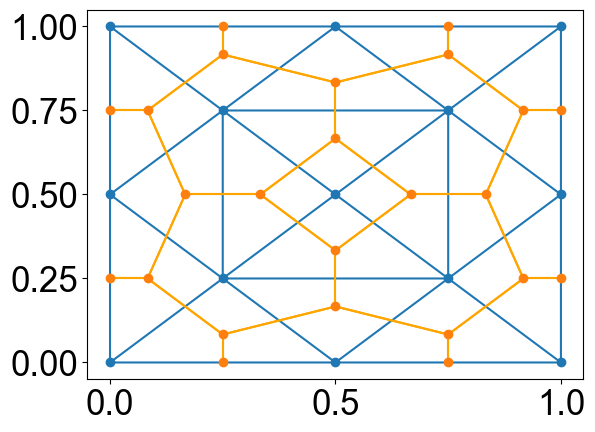

C:\Users\zani\AppData\Local\Temp\ipykernel_8520\2386135632.py:236: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  cross_prod = np.cross(B - A, C - A)


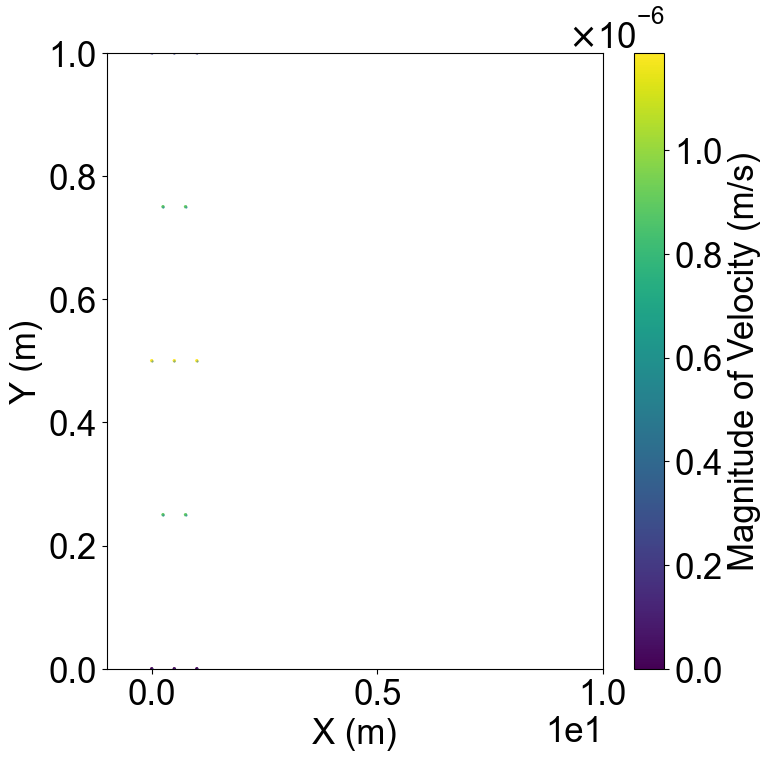

Error = 7.411427218125002e-12


In [243]:
# Solid boundaries of plate
x_lb = 0
x_ub = R  # For simplicity
y_lb = 0
y_ub = R  # Actual parallel plate dimension
domain = [(x_lb, x_ub), (y_lb, y_ub)]
points = incom_Poi(domain, refinements=1)
HC, tri = triang_dual(points)
#HC.vertex_face_mesh(field_conversions=True)
HC = compute_vd_barycentric(HC)
plot_dual_mesh_2D(HC, tri)


# For each vertex compute its local dual area:

Areas = []
for vp1 in HC.V:
    area = 0
    area += d_area_barycentric(vp1)
    Areas.append(area)

# Set ICs:
mass_IC(HC)  # mass IC
v_IC(HC)  # Velocity IC
P_IC(HC)  # Pressure field IC

# Plot IC velocity field
p = []
u = []
for v in HC.V:
    p.append(v.x_a)
    u.append(v.u)

p = np.array(p)
u = np.array(u)
plot_field(p, u)
print(f'Error = {v_error(HC)}')

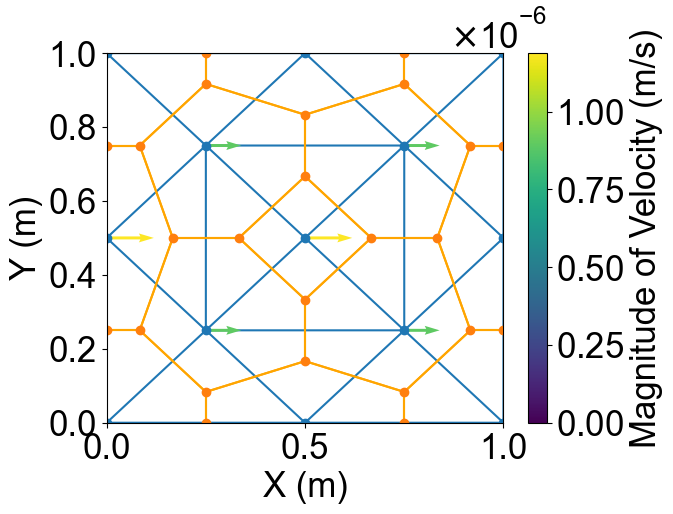

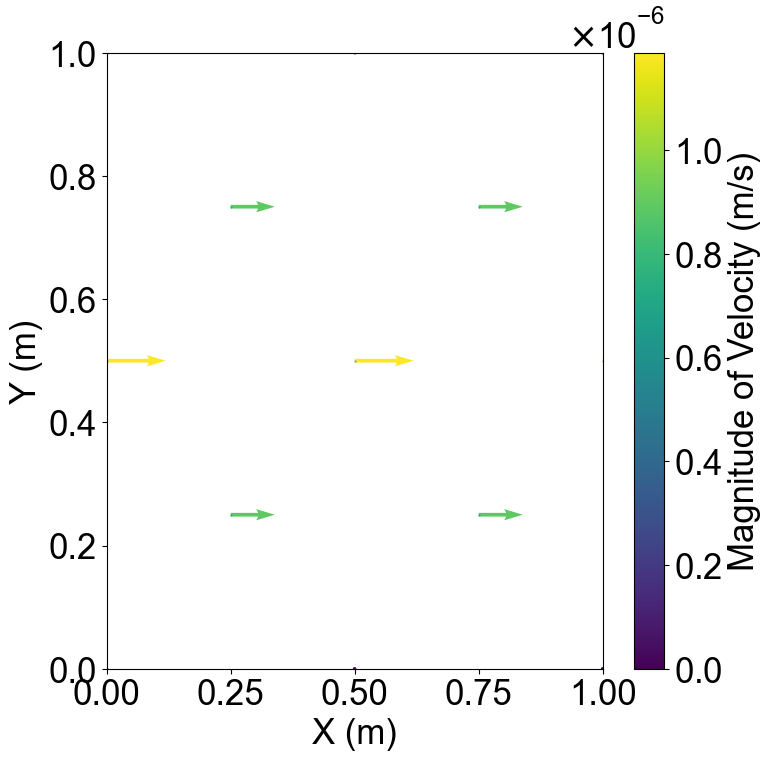

Error = 7.411427218125002e-12


In [244]:
mpl.rcParams['font.size'] = 25#30
plot_discrete_field(p, u, HC, tri, scale=1e-5)

mpl.rcParams['font.size'] = 25
# Plot IC velocity field
p = []
u = []
for v in HC.V:
    p.append(v.x_a)
    u.append(v.u)

p = np.array(p)
u = np.array(u)
plot_field(p, u, xlim_lb=0, xlim_ub=1, scale=1e-5)
print(f'Error = {v_error(HC)}')

### Test 1 — Laplacian of constant pressure


In [245]:
lap_P = np.array([laplace_P(v) for v in HC.V])
print("Sum over domain (must be ~0):", np.sum(lap_P))
print("Mean value:", np.mean(lap_P))
print("Std (can be nonzero):", np.std(lap_P))


Sum over domain (must be ~0): 1.387861076063146e-10
Mean value: 5.337927215627485e-12
Std (can be nonzero): 0.036163651462055246


C:\Users\zani\AppData\Local\Temp\ipykernel_8520\2386135632.py:236: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  cross_prod = np.cross(B - A, C - A)


### Test 2 — Global conservation of divergence of velocity
Integrated divergence over all control volumes must vanish.


In [246]:
total_div = 0.0
for v in HC.V:
    total_div += div_u(v)

print("Total divergence (must be ~0):", total_div)


Total divergence (must be ~0): -1.3234889800848443e-23


### Test 3 — Constant null-space for pressure and velocity
Grad(constant pressure) = 0, Laplacian(constant velocity) = 0


In [247]:
# Constant pressure
for v in HC.V:
    v.P = 3

grad_norms = [np.linalg.norm(dP(v)) for v in HC.V]
print("Grad(constant pressure):", max(grad_norms))

# Constant velocity
for v in HC.V:
    v.u = np.array([1.0, -0.3])

laplace_norms = [np.linalg.norm(du(v)) for v in HC.V]
print("max Laplace(constant velocity):", max(laplace_norms))


Grad(constant pressure): 0.0
max Laplace(constant velocity): 0.0


### Test 4 — Energy dissipation
Viscous operator must be negative semi-definite.

#### Explanation of `E = sum_v v.u · du(v)`

This quantity represents the **discrete viscous dissipation** in our system.


#### Continuous analogy

For an incompressible Newtonian fluid, the viscous dissipation rate is:


$$
\Phi = \int_\Omega \mathbf{u} \cdot \mu \Delta \mathbf{u} \, dV
$$






In [248]:
E = 0.0
for v in HC.V:
    E += np.dot(v.u, du(v))

print("Dissipation (must be ≤ 0):", E)


Dissipation (must be ≤ 0): 0.0


### Test 5 — Local divergence scaling


In [249]:
div_local = []
for v in HC.V:
    div_i = div_u(v) / d_area_barycentric(v)  # div_u(v) already sums fluxes
    div_local.append(div_i)

div_local = np.array(div_local)
print("Mean local divergence:", np.mean(div_local))
print("Std  local divergence:", np.std(div_local))



Mean local divergence: 0.0
Std  local divergence: 0.0


C:\Users\zani\AppData\Local\Temp\ipykernel_8520\2386135632.py:236: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  cross_prod = np.cross(B - A, C - A)


### Test 6 — Stokes balance residual
−∇p + μΔu = 0 (integrated sense)


In [250]:
res = []
for v in HC.V:
    r = -dP(v) + mu * du(v)
    res.append(np.linalg.norm(r))

res = np.array(res)

print("Max residual :", np.max(res))
print("Mean residual:", np.mean(res))


Max residual : 0.0
Mean residual: 0.0
